In [1]:
# Load dataset and show a quick peek
import pandas as pd

# Edit this path if your file lives elsewhere
CSV_PATH = r"C:\Users\Vex\Desktop\football\dataset\matchday\clean_matchday_stat.csv"

df = pd.read_csv(CSV_PATH)
print("df loaded:", df.shape, "| columns:", len(df.columns))
df.head(2)


df loaded: (306, 77) | columns: 77


,home_team,away_team,home_score,away_score,season_year,Date_day,Date_hour,first_half,second_half,home_team_goals_current_time,...,Attacks_Home,Attacks_Host,Dangerous_Attacks_Home,Dangerous_Attacks_Host,Distance_Covered_(km)_Home,Distance_Covered_(km)_Host,referee,venue,capacity,attendance
0,Bayer Leverkusen,Augsburg,2,1,2023/2024,18.05,16:30,"""2 - 0""","""0 - 1""","[""12'"", ""27'""]",...,150,66,84,32,118.0,118.0,Jollenbeck M. (Ger),BayArena (Leverkusen),30 210,30 210
1,Dortmund,Darmstadt,4,0,2023/2024,18.05,16:30,"""2 - 0""","""2 - 0""","[""30'"", ""38'"", ""72'"", ""88'""]",...,117,58,66,27,104.0,107.0,Siebert D. (Ger),Signal Iduna Park (Dortmund),81 365,81 365


In [2]:
# Build a team-perspective long table (reuses existing `long` if already defined)
import numpy as np
import pandas as pd

def _pick(df, options):
    for c in options:
        if c in df.columns: return c
    return None

# If a compatible `long` exists, reuse it
need_cols = {"team","opponent","venue","gf","ga"}
_have_long = ("long" in globals()) and need_cols.issubset(set(long.columns))

if not _have_long:
    # Resolve most-likely column names
    H   = _pick(df, ["home_team","HomeTeam","home","Home"])
    A   = _pick(df, ["away_team","AwayTeam","away","Away"])
    FTHG= _pick(df, ["home_score","FTHG","home_final_goal","home_fulltime_goals"])
    FTAG= _pick(df, ["away_score","FTAG","away_final_goal","away_fulltime_goals"])

    XGH = _pick(df, ["expected_goals_xg_home","home_xg","xg_home","Home_xG"])
    XGA = _pick(df, ["expected_goals_xg_host","away_xg","xg_away","Away_xG"])

    POSH= _pick(df, ["Ball_Possession_Home","Possession_Home"])
    POSA= _pick(df, ["Ball_Possession_Host","Possession_Host"])

    SOGH= _pick(df, ["Shots_on_Goal_Home","Shots_On_Goal_Home"])
    SOGA= _pick(df, ["Shots_on_Goal_Host","Shots_On_Goal_Host"])

    SHH = _pick(df, ["Goal_Attempts_Home","Total_Shots_Home","Shots_Home"])
    SHA = _pick(df, ["Goal_Attempts_Host","Total_Shots_Host","Shots_Host"])

    CORH= _pick(df, ["Corner_Kicks_Home","Corners_Home"])
    CORA= _pick(df, ["Corner_Kicks_Host","Corners_Away","Corners_Host"])

    FKH = _pick(df, ["Free_Kicks_Home"])
    FKA = _pick(df, ["Free_Kicks_Host"])

    SAVH= _pick(df, ["Goalkeeper_Saves_Home","Saves_Home"])
    SAVA= _pick(df, ["Goalkeeper_Saves_Host","Saves_Away","Saves_Host"])

    PASS_T_H = _pick(df, ["Total_Passes_Home"])
    PASS_T_A = _pick(df, ["Total_Passes_Host"])
    PASS_C_H = _pick(df, ["Completed_Passes_Home"])
    PASS_C_A = _pick(df, ["Completed_Passes_Host"])

    DANGH= _pick(df, ["Dangerous_Attacks_Home"])
    DANGA= _pick(df, ["Dangerous_Attacks_Host"])

    # Optional: precomputed match probabilities
    PW   = _pick(df, ["p_home_win","prob_home_win","_pH"])
    PD   = _pick(df, ["p_draw","prob_draw","_pD"])
    PLA  = _pick(df, ["p_away_win","prob_away_win","_pA"])

    assert all(c is not None for c in [H,A,FTHG,FTAG]), "Could not resolve basic match columns."

    # Numeric coercions where applicable
    for c in [FTHG,FTAG,XGH,XGA,POSH,POSA,SOGH,SOGA,SHH,SHA,CORH,CORA,FKH,FKA,SAVH,SAVA,PASS_T_H,PASS_T_A,PASS_C_H,PASS_C_A,DANGH,DANGA,PW,PD,PLA]:
        if c and c in df.columns:
            df[c] = pd.to_numeric(df[c], errors="coerce")

    # Build home/away rows from the same match table
    home = pd.DataFrame({
        "team": df[H], "opponent": df[A], "venue": "Home",
        "gf": df[FTHG], "ga": df[FTAG],
        "xg_for": df[XGH] if XGH else np.nan,
        "xg_against": df[XGA] if XGA else np.nan,
        "pos": df[POSH] if POSH else np.nan,
        "sog": df[SOGH] if SOGH else np.nan,
        "shots": df[SHH] if SHH else np.nan,
        "corners": df[CORH] if CORH else np.nan,
        "fks": df[FKH] if FKH else np.nan,
        "saves": df[SAVH] if SAVH else np.nan,
        "pass_tot": df[PASS_T_H] if PASS_T_H else np.nan,
        "pass_cmp": df[PASS_C_H] if PASS_C_H else np.nan,
        "dang": df[DANGH] if DANGH else np.nan,
        "pW": df[PW] if PW else np.nan,
        "pD": df[PD] if PD else np.nan,
        "pL": df[PLA] if PLA else np.nan,
    })
    away = pd.DataFrame({
        "team": df[A], "opponent": df[H], "venue": "Away",
        "gf": df[FTAG], "ga": df[FTHG],
        "xg_for": df[XGA] if XGA else np.nan,
        "xg_against": df[XGH] if XGH else np.nan,
        "pos": df[POSA] if POSA else np.nan,
        "sog": df[SOGA] if SOGA else np.nan,
        "shots": df[SHA] if SHA else np.nan,
        "corners": df[CORA] if CORA else np.nan,
        "fks": df[FKA] if FKA else np.nan,
        "saves": df[SAVA] if SAVA else np.nan,
        "pass_tot": df[PASS_T_A] if PASS_T_A else np.nan,
        "pass_cmp": df[PASS_C_A] if PASS_C_A else np.nan,
        "dang": df[DANGA] if DANGA else np.nan,
        "pW": df[PLA] if PLA else np.nan,  # swapped perspective
        "pD": df[PD] if PD else np.nan,
        "pL": df[PW] if PW else np.nan,
    })
    long = pd.concat([home, away], ignore_index=True)

# Opponent-aligned column for ratios (mirror each match)
def _opp_aligned(col):
    if col not in long.columns: return None
    n = len(long)//2
    vals = long[col].to_numpy()
    return np.concatenate([vals[n:], vals[:n]])

# Derived KPIs (guard against missing inputs)
if "pass_pct" not in long.columns and {"pass_tot","pass_cmp"}.issubset(long.columns):
    long["pass_pct"] = long["pass_cmp"].astype(float) / long["pass_tot"].replace(0, np.nan).astype(float)

if "field_tilt" not in long.columns and "dang" in long.columns:
    da_for = long["dang"].astype(float)
    da_opp = pd.Series(_opp_aligned("dang"), index=long.index).astype(float)
    long["field_tilt"] = da_for / (da_for + da_opp)

if "save_rate" not in long.columns and "saves" in long.columns:
    sog_opp = _opp_aligned("sog")
    if sog_opp is not None:
        long["save_rate"] = long["saves"].astype(float) / pd.Series(sog_opp, index=long.index).replace(0, np.nan).astype(float)

# Expected points (optional: requires pW/pD)
if "xPts" not in long.columns:
    if {"pW","pD"}.issubset(long.columns):
        long["xPts"] = 3*pd.to_numeric(long["pW"], errors="coerce") + pd.to_numeric(long["pD"], errors="coerce")
    else:
        long["xPts"] = np.nan

for c in ["gf","ga","xg_for","xg_against","pos","sog","shots","corners","fks","pass_pct","field_tilt","save_rate","xPts"]:
    if c in long.columns:
        long[c] = pd.to_numeric(long[c], errors="coerce")

print("KPI table ready. Rows:", len(long), "| Columns:", sorted(long.columns.tolist()))
long.head(3)


KPI table ready. Rows: 612 | Columns: ['corners', 'dang', 'field_tilt', 'fks', 'ga', 'gf', 'opponent', 'pD', 'pL', 'pW', 'pass_cmp', 'pass_pct', 'pass_tot', 'pos', 'save_rate', 'saves', 'shots', 'sog', 'team', 'venue', 'xPts', 'xg_against', 'xg_for']


,team,opponent,venue,gf,ga,xg_for,xg_against,pos,sog,shots,...,pass_tot,pass_cmp,dang,pW,pD,pL,pass_pct,field_tilt,save_rate,xPts
0,Bayer Leverkusen,Augsburg,Home,2,1,2.86,0.77,NaN,8,19,...,728,670,84,NaN,NaN,NaN,0.920330,0.724138,0.5,NaN
1,Dortmund,Darmstadt,Home,4,0,2.83,0.42,NaN,10,21,...,727,669,66,NaN,NaN,NaN,0.920220,0.709677,1.0,NaN
2,Eintracht Frankfurt,RB Leipzig,Home,2,2,2.02,1.73,NaN,6,19,...,432,354,49,NaN,NaN,NaN,0.819444,0.636364,0.6,NaN


In [3]:
# Modeling utilities: pipelines, CV, importances, and contribution charts
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import ElasticNetCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.inspection import permutation_importance
from sklearn.model_selection import KFold
from sklearn.metrics import make_scorer, mean_absolute_error
from scipy.stats import ttest_rel

def pick_name(names, hint):
    m = [t for t in names if isinstance(t,str) and hint.lower() in t.lower()]
    return m[0] if m else None

def make_model_frames(long, feature_list, target_col):
    dfm = long.copy()
    dfm["home_bin"] = (dfm["venue"].astype(str).str.lower()=="home").astype(int)
    if target_col == "gd":
        dfm["gd"] = pd.to_numeric(dfm["gf"], errors="coerce") - pd.to_numeric(dfm["ga"], errors="coerce")
        y = dfm["gd"].astype(float)
    else:
        y = pd.to_numeric(dfm[target_col], errors="coerce")
    X = dfm[feature_list + ["home_bin"]].astype(float)
    return dfm, X, y

def grouped_cv_indices(dfm):
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    return list(kf.split(dfm))

def run_models(X, y):
    en_pipe = Pipeline([
        ("imp", SimpleImputer(strategy="median")),
        ("sc", StandardScaler(with_mean=True, with_std=True)),
        ("en", ElasticNetCV(l1_ratio=[0.05,0.25,0.5,0.75,0.95,1.0], cv=5, random_state=42, max_iter=5000))
    ])
    gbr_pipe = make_pipeline(SimpleImputer(strategy="median"),
                             StandardScaler(with_mean=True, with_std=True),
                             GradientBoostingRegressor(random_state=42))
    idx_splits = grouped_cv_indices(X)
    en_fold_mae, gbr_fold_mae = [], []
    for tr, te in idx_splits:
        en_pipe.fit(X.iloc[tr], y.iloc[tr])
        gbr_pipe.fit(X.iloc[tr], y.iloc[tr])
        en_fold_mae.append(np.mean(np.abs(en_pipe.predict(X.iloc[te]) - y.iloc[te])))
        gbr_fold_mae.append(np.mean(np.abs(gbr_pipe.predict(X.iloc[te]) - y.iloc[te])))
    en_pipe.fit(X, y)
    gbr_pipe.fit(X, y)
    return en_pipe, gbr_pipe, np.array(en_fold_mae), np.array(gbr_fold_mae)

def report_cv(en_mae, gbr_mae):
    print(f"Elastic Net per-fold MAE: {np.round(en_mae,3)}  | mean {en_mae.mean():.3f}")
    print(f"GBR per-fold MAE:        {np.round(gbr_mae,3)}  | mean {gbr_mae.mean():.3f}")
    t, p = ttest_rel(en_mae, gbr_mae, alternative="greater")
    print(f"Paired t-test (EN MAE > GBR MAE): t={t:.2f}, p={p:.4f}")

def plot_perm_importance(pipeline, X, y, title):
    r = permutation_importance(
        pipeline, X, y,
        n_repeats=12, random_state=42,
        scoring="neg_mean_absolute_error"
    )
    # importances_mean ~ ΔMAE when shuffled (higher → more important)
    imp = pd.Series(r.importances_mean, index=X.columns).sort_values()
    plt.figure(figsize=(8,5))
    plt.barh(imp.index, imp.values)
    plt.title(title)
    plt.xlabel("Δ MAE when shuffled (higher = more important)")
    plt.xlim(left=0)
    plt.grid(True, axis="x", alpha=0.3)
    plt.tight_layout()
    plt.show()

def contribution_table(pipeline, Xcols, league_mean, team_mean):
    def _pred(row_like):
        df1 = pd.DataFrame([row_like], columns=Xcols)
        return float(pipeline.predict(df1)[0])
    base_pred = _pred(league_mean)
    rows=[]
    for f in Xcols:
        r = league_mean.copy()
        r[f] = team_mean[f]
        rows.append((f, _pred(r) - base_pred))
    return pd.DataFrame(rows, columns=["feature","contribution"]).sort_values("contribution")

def plot_contrib(tab, team_name, model_name, ylabel="Δ predicted goal difference"):
    tab2 = tab[tab["feature"]!="home_bin"].copy()
    plt.figure(figsize=(8.6,5.2))
    plt.barh(tab2["feature"], tab2["contribution"])
    plt.axvline(0, color="k", lw=1)
    plt.title(f"{team_name} KPI contributions vs league-average — {model_name}\n(positive → higher expected value per match)")
    plt.xlabel(ylabel)
    plt.grid(True, axis="x", alpha=0.3)
    plt.tight_layout(); plt.show()


Feature coverage ≥60%: ['pass_pct', 'field_tilt', 'shots', 'sog', 'xg_for', 'xg_against', 'save_rate', 'corners', 'fks']
Elastic Net per-fold MAE: [0.899 0.996 0.838 1.055 1.043]  | mean 0.966
GBR per-fold MAE:        [0.882 0.896 0.837 1.048 1.01 ]  | mean 0.935
Paired t-test (EN MAE > GBR MAE): t=1.75, p=0.0776


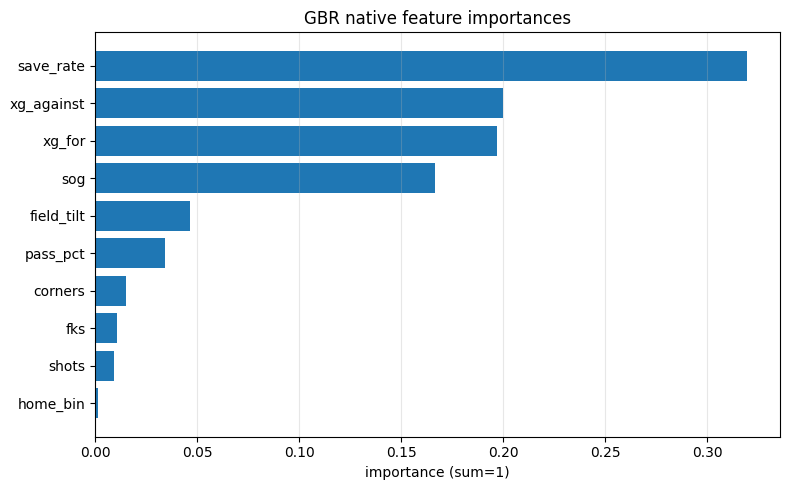

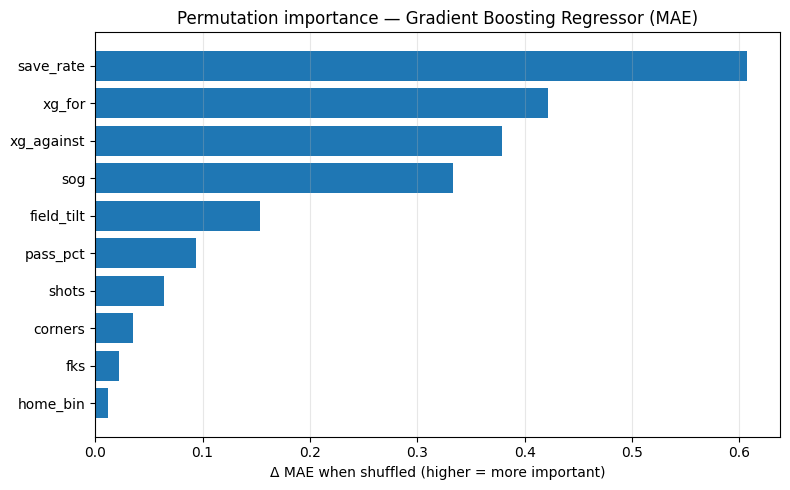

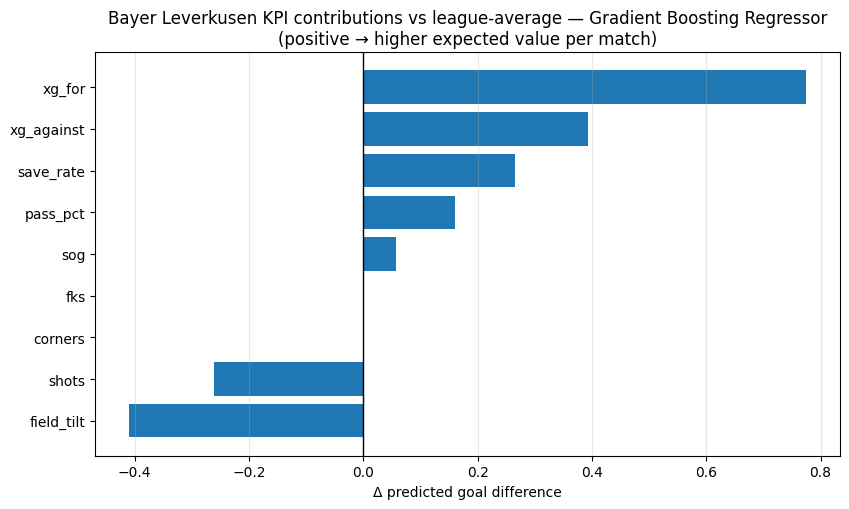

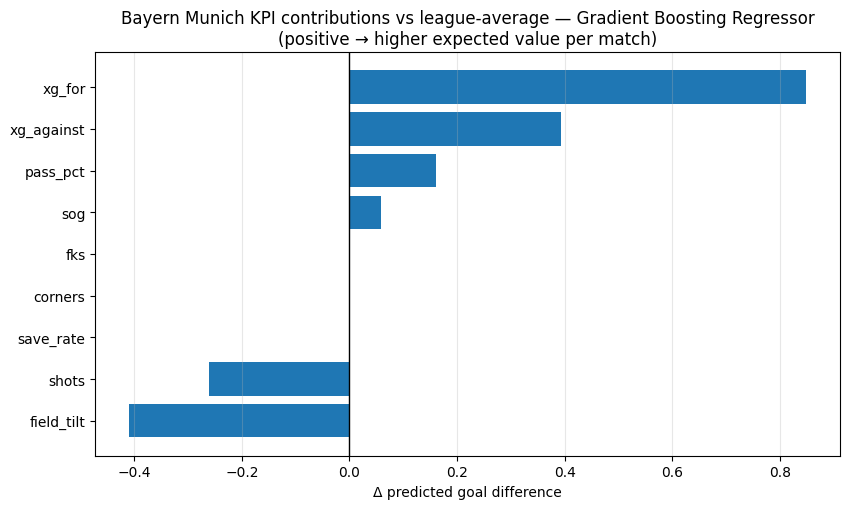

In [4]:
# Train EN & GBR on goal difference, compare MAE, then plot importances and team contributions
# Keep only KPIs with enough coverage
kpi_candidates = ["pos","pass_pct","field_tilt","shots","sog","xg_for","xg_against","save_rate","corners","fks"]
cov = pd.Series({c: long[c].notna().mean() if c in long.columns else 0 for c in kpi_candidates})
Xfeat = list(cov[cov >= 0.60].index)   # require ≥60% non-missing
print("Feature coverage ≥60%:", Xfeat)

dfm, X, y = make_model_frames(long, Xfeat, target_col="gd")
en_pipe, gbr_pipe, en_mae, gbr_mae = run_models(X, y)
report_cv(en_mae, gbr_mae)

# Native tree importances (if available)
gb = gbr_pipe.named_steps.get("gradientboostingregressor", None)
if gb is not None:
    fi = pd.Series(gb.feature_importances_, index=X.columns).sort_values()
    plt.figure(figsize=(8,5))
    plt.barh(fi.index, fi.values)
    plt.title("GBR native feature importances")
    plt.xlabel("importance (sum=1)")
    plt.grid(True, axis="x", alpha=0.3)
    plt.tight_layout(); plt.show()

# Permutation importance on GBR
plot_perm_importance(gbr_pipe, X, y, title="Permutation importance — Gradient Boosting Regressor (MAE)")

# Contribution bars for two teams against league-average
teams_available = sorted(dfm["team"].dropna().unique())
TEAM_L = pick_name(teams_available, "Leverkusen") or "Bayer Leverkusen"
TEAM_B = pick_name(teams_available, "Bayern")     or "Bayern Munich"

league_mean = X.mean()
lev_mean = dfm[dfm["team"]==TEAM_L][X.columns].mean()
bay_mean = dfm[dfm["team"]==TEAM_B][X.columns].mean()

lev_tab = contribution_table(gbr_pipe, X.columns, league_mean, lev_mean)
bay_tab = contribution_table(gbr_pipe, X.columns, league_mean, bay_mean)

plot_contrib(lev_tab, TEAM_L, model_name="Gradient Boosting Regressor", ylabel="Δ predicted goal difference")
plot_contrib(bay_tab, TEAM_B, model_name="Gradient Boosting Regressor", ylabel="Δ predicted goal difference")
